# ADA Project: MileStone2

## While way-finding in information network, human is a *Genius* or a *Lazybone*?

*Wikipeedia* is a human-computation game based on articles in Wikipedia. Users are asked to navigate from a source article to a specific target one, through clicking the links appeared in each Wikipedia article. Different from how a computer plays the game, humans will not always choose the shortest path to reach the destination word from the source one.
We summary the human's "clicking process" into two main steps:
<ol>
<li>People first establish a logical chain (clear or blurry) which connect the source word to the destination, preliminarily. This part is based on people's priori knowledge.</li>
<br>
<li>While scanning the HTML page, people change their initial logical chain and finish their "clicking task". People make their shift according to the HTML they see, i.e. textplain, images in the page. </li>
</ol>

We will process our analyse according to this two steps. In the first part, we use the model LDA to grasp points about how people link the source and target. In the second stage, we analyze the finished path and unfinished path to find people's clicking tendency based on the article they scan.

### Content

1. Basic analysis on the dataset
2. Logical chain exploration using the LDA model
3. Clicking tendency based on HTML pages


### Useful libraries

In [118]:
# Utilitaries
import pandas as pd
import os

# Math
import numpy as np
from scipy import stats

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 100)

### Data Importation

We will import the data in file "paths_finished.tsv", "article.tsv" and "categories.tsv" into DataFrame

In [120]:
# Reading the 'paths_finished.tsv' file as a pandas dataframe
PATH_DATASET = "../dataset"
fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/paths_finished.tsv')
df_finished_path = pd.read_csv("../dataset/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', comment = '#', header=None, names = ['hashedIpAddress','timestamp','durationInSec','path','rating'], encoding = 'UTF-8')

df_finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0


In [121]:
# Reading the 'categories.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/categories.tsv')
df_categories = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles','category'], encoding = 'UTF-8')
df_categories.head()

,articles,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_Countries
4,%C3%89douard_Manet,subject.People.Artists


In [122]:
# Reading the 'articles.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/articles.tsv')
df_article = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles'],encoding = 'UTF-8')
df_article.head()

,articles
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


### First glance at the data

We first analyse each file, respectively. And then we will merge files together to delve more points.

#### Analyse each file independently. We will generate more datas in the dataframe.
Files are "paths_finished.tsv" and "categories.tsv"

**1. paths_finished.tsv**

We calculate the path length and store the value in column **path_length**. For example if the path is "Yagan; Ancient_Egypt; Civilization", the path length is 2.

In [123]:
def calculate_path_length(x):
    string_array = x.split(';')
    return len(string_array)-1

df_finished_path['path_length'] = df_finished_path['path'].apply(calculate_path_length)

We extract the source and the target word from the path and store them in column **source** and **destination**, respectively.

In [124]:
def path_source(x):
    string_array = x.split(';')
    return string_array[0]


def path_destination(x):
    string_array = x.split(';')
    return string_array[-1]

df_finished_path['source'] = df_finished_path['path'].apply(path_source)
df_finished_path['destination'] = df_finished_path['path'].apply(path_destination)

We construct the data "path pair". For example, if the path is "A; B; C", then the path pair will be [(A, B), (B, C)]

In [125]:
df_finished_path['path_pair'] = None

i = 0
path_pair_dict = {}
for index, row in df_finished_path['path'].items():
    string_path_pair = []
    string_array = row.split(";")
    for pair_index in range(len(string_array) - 1):
        string_pair = '(' + string_array[pair_index] + ', ' + string_array[pair_index + 1] + ')'
        string_path_pair.append(string_pair)
        path_pair_dict[string_pair] = path_pair_dict.get(string_pair, 0) + 1
    df_finished_path['path_pair'][i] = string_path_pair
    i += 1

In [126]:
df_finished_path.head(5)

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3,14th_century,Greece,"[(14th_century, Renaissance), (Renaissance, Ancient_Greece), (Ancient_Greece, Greece)]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona..."


Dataframe **df_finished_path** variables

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

Analyze the data in dataframe df_finished_path

##### Variable: path length

First, we anlyse the variable path_length. We draw the histogram of it.

Text(0.5, 1.0, 'Path Length Frequency Histogram')

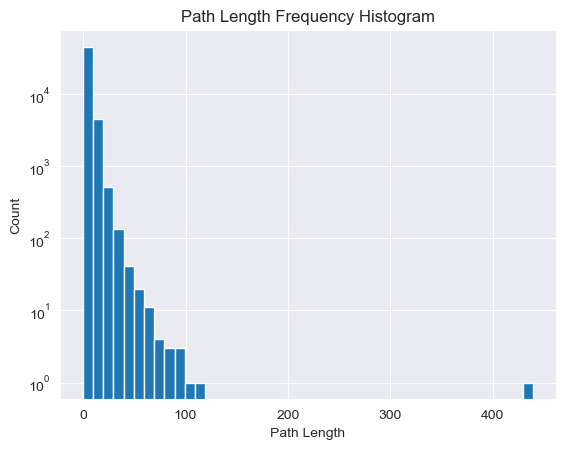

In [127]:
df_finished_path['path_length'].plot.hist(bins=np.arange(-0.5,440.5, 10), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram")

From the histogram, we could find that the path length mainly concentrates on the range(0, 100). There are also outliers lie at 400+. In order to remove the special situations during the game playing, we set the range of bins to 10. And we consider that the path length frequency in each bin, which is smaller than 10, as outliers. We remove the path length larger than 70.


In [128]:
df_finished_path_rm_outlier = df_finished_path[df_finished_path['path_length'] <= 70]

We also find there are data whose path_length equals to 0. It means that the target article is same to to source one. We also remove this situation.

In [129]:
df_finished_path_rm_outlier = df_finished_path_rm_outlier[df_finished_path_rm_outlier['path_length'] != 0]

Text(0.5, 1.0, 'Path Length Frequency Histogram without Outliers')

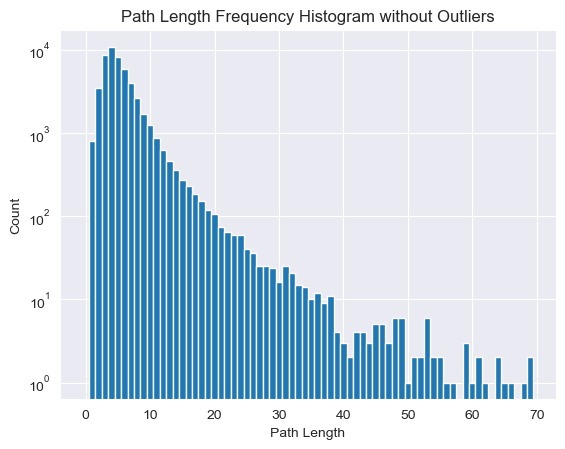

In [130]:
df_finished_path_rm_outlier['path_length'].plot.hist(bins=np.arange(-0.5,70.5,1), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram without Outliers")

##### Variable: rating and path_length

We want to find that whether the rate is related to the path length

In [131]:
## Is rating related to steps?

# use only data with rating
df_rate = df_finished_path_rm_outlier[df_finished_path_rm_outlier['rating']>0]
df_rate.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona..."
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0,3,14th_century,Fire,"[(14th_century, China), (China, Gunpowder), (Gunpowder, Fire)]"
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rainbow,1.0,5,14th_century,Rainbow,"[(14th_century, Time), (Time, Isaac_Newton), (Isaac_Newton, Light), (Light, Color), (Color, Rain..."
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0,3,14th_century,Rainbow,"[(14th_century, Time), (Time, Light), (Light, Rainbow)]"


We draw the boxplot with the variable data path_length and rating.

In [132]:
print('Average steps for each rating')
for i in range(5):
    print('rating =',i+1)
    print('number:',df_rate[df_rate.rating == i+1].path_length.count(), 'mean:',df_rate[df_rate.rating == i+1].path_length.mean())

Average steps for each rating
rating = 1
number: 8542 mean: 3.6661203465230625
rating = 2
number: 8792 mean: 5.001592356687898
rating = 3
number: 7261 mean: 6.645503374190882
rating = 4
number: 2746 mean: 9.02804078659869
rating = 5
number: 1150 mean: 11.475652173913044


Text(0.5, 1.0, 'Boxplot of Path Length and Rating')

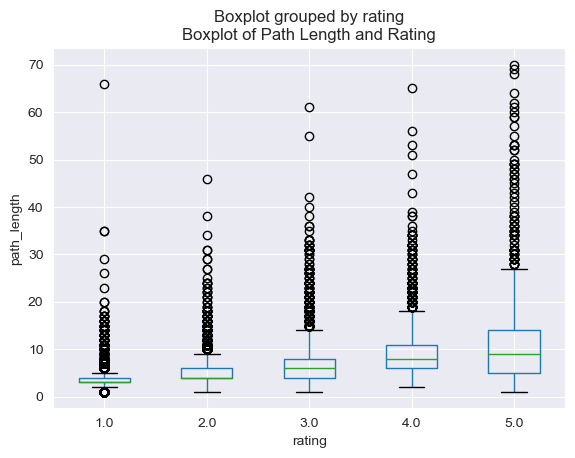

In [133]:
# df_rate.plot.scatter(x='steps', y='rating')
df_rate.boxplot(column=['path_length'], by=['rating'])
plt.xlabel("rating")
plt.ylabel("path_length")
plt.title("Boxplot of Path Length and Rating")

From the above plot, we find that the rating is related to the path length. And longer path will have a higher rate. We will delve this part in our later project.

**2. categories.tsv**

We calculate the hierarchical depth of variable category

In [134]:
def calculate_category_length(x):
    string_array = x.split('.')
    return len(string_array)


df_categories['category_length'] = df_categories['category'].apply(calculate_category_length)

We extract the 1st depth category and store the data in the column **category_1st**

In [135]:
df_categories['category_1st'] = df_categories.apply(lambda x:x.category.split('.')[1], axis = 1)

In [136]:
df_categories.head(5)

,articles,category,category_length,category_1st
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,4,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,3,People
2,%C3%85land,subject.Countries,2,Countries
3,%C3%85land,subject.Geography.European_Geography.European_Countries,4,Geography
4,%C3%89douard_Manet,subject.People.Artists,3,People


Dataframe **df_categories** variables

`articles`: the name of the article

`category`: the category that the article belongs to

`category_length`: the hierarchical depth of the variable category

`category_1st`: the 1st category that the article belongs to

Analyze the data in dataframe df_categories

##### Variable: category_length

We first count the frequency according to the variable category_length. There are 274 articles which category depth equals to 2. 3448 articles which category depth equals to 3. 1482 articles which category depth equals to 4.

In [137]:
df_categories['category_length'].value_counts()

3    3448
4    1482
2     274
Name: category_length, dtype: int64

Then, we check the category with different depth in details.

In [138]:
category_dict_1 = {}
category_dict_2 = {}
category_dict_3 = {}

for index, row in df_categories['category'].items():
    string_path_pair = []
    string_array = row.split(".")
    for index in range(len(string_array)):
        if index == 1:
            category_dict_1[string_array[index]] = category_dict_1.get(string_array[index], 0) + 1
        elif index == 2:
            category_dict_2[string_array[index]] = category_dict_2.get(string_array[index], 0) + 1
        elif index == 3:
            category_dict_3[string_array[index]] = category_dict_3.get(string_array[index], 0) + 1

We check the categories at the depth 1. Key is the category and the value is the number of articles in this cateogory.

In [139]:
print("There are {} categories at depth 1".format(len(category_dict_1)))
category_dict_1

There are 15 categories at depth 1


{'History': 545,
 'People': 689,
 'Countries': 229,
 'Geography': 1084,
 'Business_Studies': 88,
 'Science': 1122,
 'Everyday_life': 374,
 'Design_and_Technology': 254,
 'Music': 97,
 'IT': 85,
 'Language_and_literature': 196,
 'Mathematics': 45,
 'Religion': 134,
 'Art': 38,
 'Citizenship': 224}

We check the categories at the depth 2. Key is the category and the value is the number of articles in this cateogory.

In [140]:
print("There are {} categories at depth 1".format(len(category_dict_2)))
category_dict_2

There are 101 categories at depth 1


{'British_History': 158,
 'Historical_figures': 108,
 'European_Geography': 139,
 'Artists': 38,
 'Currency': 14,
 'General_history': 80,
 'Military_History_and_War': 71,
 'Physics': 226,
 'Sports_events': 22,
 'Storms': 33,
 'Recent_History': 48,
 'Geology_and_geophysics': 76,
 'Natural_Disasters': 39,
 'Railway_transport': 84,
 'Sports_and_games_people': 45,
 'Biology': 704,
 'Performers_and_composers': 59,
 'Computing_hardware_and_infrastructure': 20,
 'Companies': 18,
 'Novels': 39,
 'Musical_genres_styles_eras_and_events': 46,
 'Everyday_life': 27,
 'Geography_of_the_Middle_East': 36,
 'Ancient_History_Classical_History_and_Mythology': 87,
 'Religious_movements_traditions_and_organizations': 35,
 'Theatre': 32,
 'Geographers_and_explorers': 21,
 'Geography_of_Great_Britain': 124,
 'Religious_texts': 18,
 'African_Geography': 137,
 'Geography_of_Asia': 106,
 'Writers_and_critics': 71,
 'USA_Presidents': 37,
 'Drink': 15,
 'Art': 36,
 'Business': 28,
 'Chemistry': 192,
 'Environment

We check the categories at the depth 3. Key is the category and the value is the number of articles in this cateogory.

In [141]:
print("There are {} categories at depth 1".format(len(category_dict_3)))
category_dict_3

There are 27 categories at depth 1


{'British_History_1500_and_before_including_Roman_Britain': 73,
 'European_Countries': 56,
 'Space_Astronomy': 105,
 'Health_and_medicine': 109,
 'General_Physics': 55,
 'Mammals': 114,
 'Plants': 108,
 'British_History_15001750': 29,
 'Asian_Countries': 37,
 'Middle_Eastern_Countries': 18,
 'Chemical_compounds': 42,
 'Chemical_elements': 119,
 'General_Biology': 51,
 'Birds': 161,
 'Insects_Reptiles_and_Fish': 72,
 'Dinosaurs': 59,
 'General_Chemistry': 21,
 'African_Countries': 57,
 'Central_and_South_American_Countries': 48,
 'Space_transport': 33,
 'British_History_17501900': 24,
 'Organisms': 19,
 'British_History_Post_1900': 18,
 'Electricity_and_Electronics': 20,
 'Evolution_and_reproduction': 11,
 'Materials_science': 10,
 'The_Planets': 13}

**3. articles.tsv**

We create the column **num** as the number index

In [142]:
## record index and change index to articles names

df_article['num'] = df_article.index.copy(deep = True)
df_article.index = df_article['articles']

Change the withdraw operation to -1

In [143]:
## add withdraw '<'
df_article.loc['<'] = -1

In [144]:
df_article.head()

,articles,num
articles,,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
%C3%85land,%C3%85land,1
%C3%89douard_Manet,%C3%89douard_Manet,2
%C3%89ire,%C3%89ire,3
%C3%93engus_I_of_the_Picts,%C3%93engus_I_of_the_Picts,4


#### Merge Data in Files together. And Analyse the Merged DataFrame

Merge the df_finished_path and df_article. The path will be converted to number index in the column **pathnum**. The path number will be used in LDA construction

In [145]:
df_finished_path_rm_outlier['pathnum'] = df_finished_path_rm_outlier.apply(lambda x:str(df_article.loc[x.path.split(';')[:]].num.tolist()), axis = 1)

In [146]:
df_finished_path_rm_outlier.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair,pathnum
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac...","[10, 12, 15, 3134, 377, 105, 128, 379, 143]"
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade...","[10, 1433, 128, 379, 143]"
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]"
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3,14th_century,Greece,"[(14th_century, Renaissance), (Renaissance, Ancient_Greece), (Ancient_Greece, Greece)]","[10, 3464, 241, 1793]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona...","[10, 2183, 3529, 1836, 3542, 3342, 2266]"


Dataframe **df_finished_path** variables

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

`pathnum`: convert the path to path number index

Merge the df_finished_path and df_categories. Every data about the articles will have their category information.
First, we extract the first article that the user click and store the data in column **first_path**

In [180]:
df_merge_finished_path_category = df_finished_path_rm_outlier.copy(deep=True)
df_merge_finished_path_category['first_path'] = df_merge_finished_path_category.apply(lambda x:x.path.split(';')[1], axis = 1)

In [181]:
df_merge_finished_path_category.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair,pathnum,first_path
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac...","[10, 12, 15, 3134, 377, 105, 128, 379, 143]",15th_century
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade...","[10, 1433, 128, 379, 143]",Europe
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]",Niger
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3,14th_century,Greece,"[(14th_century, Renaissance), (Renaissance, Ancient_Greece), (Ancient_Greece, Greece)]","[10, 3464, 241, 1793]",Renaissance
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona...","[10, 2183, 3529, 1836, 3542, 3342, 2266]",Italy


We merge the path and the category dataframe together. We create new columns called "first_category" and "first_category_length" to store the category information of the first path

In [182]:
df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories, left_on='first_path', right_on='articles')

In [183]:
df_merge_finished_path_category['first_path_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['first_path_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['first_path_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.first_path_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

We create new columns called "source_category" and "source_category_length" to store the category information of the source article. We create new columns called "dest_category" and "dest_category_length" to store the category information of the destination article.

In [184]:
df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories,left_on='source', right_on='articles')
df_merge_finished_path_category['source_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['source_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['source_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.source_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories,left_on='destination', right_on='articles')
df_merge_finished_path_category['dest_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['dest_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['dest_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.dest_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

Then, we merge the source category with the destination category and store the data in column **source_dest_category**

In [185]:
df_merge_finished_path_category['source_dest_category_1st'] = df_merge_finished_path_category['source_category_1st'].str.cat(';' + df_merge_finished_path_category['dest_category_1st'])

Then, we merge the source category with the first path category and store the data in column **source_first_path_category**

In [189]:
df_merge_finished_path_category['source_first_path_category'] = df_merge_finished_path_category['source_category_1st'].str.cat(';' + df_merge_finished_path_category['first_path_category_1st'])

In [190]:
df_merge_finished_path_category.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair,pathnum,first_path,first_path_category,first_path_category_length,first_path_category_1st,source_category,source_category_length,source_category_1st,dest_category,dest_category_length,dest_category_1st,source_dest_category_1st,source_first_path_category
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac...","[10, 12, 15, 3134, 377, 105, 128, 379, 143]",15th_century,subject.History.General_history,3,History,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,History;History
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade...","[10, 1433, 128, 379, 143]",Europe,subject.Geography.European_Geography,3,Geography,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,History;Geography
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]",Niger,subject.Geography.African_Geography.African_Countries,4,Geography,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,History;Geography
3,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]",Niger,subject.Countries,2,Countries,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,History;Countries
4,753ed9952cc780aa,1308004822,114,Bread;Ethiopia;Africa;Atlantic_slave_trade;African_slave_trade,1.0,4,Bread,African_slave_trade,"[(Bread, Ethiopia), (Ethiopia, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade, A...","[685, 1420, 128, 379, 143]",Ethiopia,subject.Geography.African_Geography.African_Countries,4,Geography,subject.Everyday_life.Food_and_agriculture,3,Everyday_life,subject.History.General_history,3,History,Everyday_life;History,Everyday_life;Geography


Dataframe **df_finished_path** variables

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

`pathnum`: convert the path to path number index

`first_path`: article that the user first click on

`first_path_category`: category of the article that the user first click on

`first_path_category_length`: length of the variable first_path_category

`first_path_category_1st`: 1st category of the article that the user first click on

`source_category`: category of the source article

`source_category_length`: length of the variable source_category

`source_category_1st`: 1st category of the source article

`dest_category`: category of the destination article

`dest_category_length`: length of the variable dest_category

`dest_category_1st`: 1st category of the destination article

`source_dest_category_1st`: category pairs contain the category of source and destination articles

`source_first_path_category`: category pairs contain the category of source and first clicking articles

Analyze the data in dataframe df_merge_finished_path_category

##### Variable: first_path_category_1st

We count the frequency of variable **first_path_category_1st**. For example, the result shows that people click the article which is in the Science category 13672 times during the whole finished path.

In [175]:
click_category_count_depth1 = df_merge_finished_path_category['first_path_category_1st'].value_counts(sort = True)
click_category_count_depth1

Geography                  35060
Countries                  17661
Science                    13672
History                     6958
Citizenship                 4066
Everyday_life               3841
Language_and_literature     3133
People                      3094
Religion                    2119
IT                          1235
Business_Studies            1076
Design_and_Technology       1062
Music                        479
Mathematics                  403
Art                          360
Name: first_path_category_1st, dtype: int64

Then, we compare the result above with the article numbers in each category. For example, there are 38 articles in the category Art. And when people play the game, there are 360 times that people choose the Art category in their first choice.

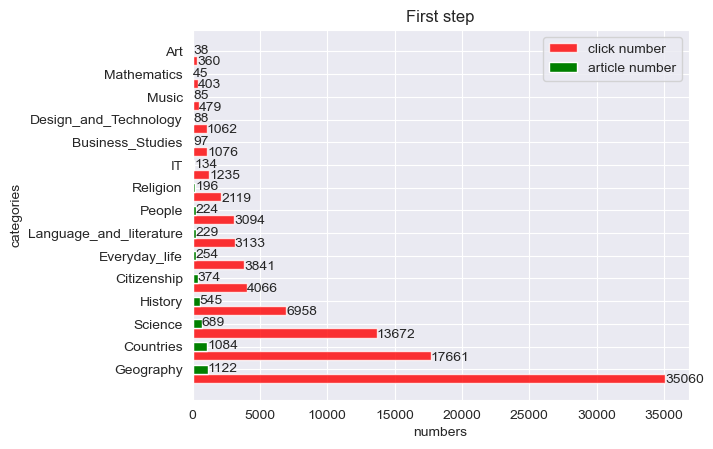

In [176]:
y = range(len(click_category_count_depth1))
catagory_values = df_categories['category_1st'].value_counts(sort = True)

rects1 = plt.barh(y=y, width=click_category_count_depth1, height=0.4, alpha=0.8, color='red', label="click number")
rects2 = plt.barh(y=[i + 0.4 for i in y], width=catagory_values, height=0.4, color='green', label="article number")

plt.xlabel("numbers")

plt.yticks([index + 0.4 for index in y], click_category_count_depth1.index)
plt.ylabel("categories")
plt.title("First step")
plt.legend()

for rect in rects1:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 - 0.2, str(width))
for rect in rects2:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 - 0.1, str(width))
plt.show()

We draw the picture which shows the ratio of article numbers in each category and the times that people choose article in this kind of category in their first choice.

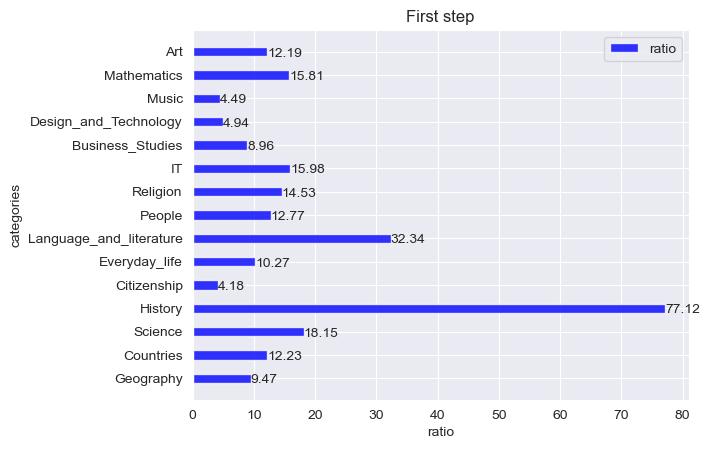

In [177]:
# ratio

rects3 = plt.barh(y=y, width = round(click_category_count_depth1/catagory_values,2), height=0.4, alpha=0.8, color='blue', label="ratio")
plt.xlabel("ratio")

plt.yticks([index  for index in y], click_category_count_depth1.index)
plt.ylabel("categories")
plt.title("First step")
plt.legend()

for rect in rects3:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 -0.2, str(width))

plt.show()

From the picture, we find that the ratio of category history is relatively high, comparing with other categories. It means that people tends to click on the article with category "history" in their first clicking choice.
Then in the later project, we could focus on the HTML in history category to find the reason why people tends to choose this kind of article.

##### Variable: source_first_path_category

Then, we get the statistic of category pairs. The category pairs contains the category of source articles and the category of articles that people choose first in their clicking process.

In [192]:
click_category_count_depth1_source_first_path = df_merge_finished_path_category['source_first_path_category'].value_counts(sort = True)
click_category_count_depth1_source_first_path

Science;Science                                    8987
Geography;Geography                                8518
Science;Geography                                  6212
People;Geography                                   3846
Everyday_life;Geography                            3585
Geography;Countries                                3557
History;Geography                                  2968
Science;Countries                                  2763
Countries;Geography                                2158
Language_and_literature;Geography                  2126
People;Countries                                   1999
Design_and_Technology;Geography                    1926
Everyday_life;Countries                            1837
Language_and_literature;Countries                  1556
History;Countries                                  1525
History;History                                    1335
Citizenship;Geography                              1321
Everyday_life;Everyday_life                     

##### Variable: source_dest_category_1st

Then, we get the statistic of category pairs. The category pairs contains the category of source articles and the category of destination articles.

In [188]:
click_category_count_depth1_source_dest = df_merge_finished_path_category['source_dest_category_1st'].value_counts(sort = True)
click_category_count_depth1_source_dest

Science;Geography                                  4600
Geography;Geography                                4519
Science;Science                                    4034
Language_and_literature;Science                    3617
Science;History                                    3492
Geography;Science                                  3342
People;Geography                                   2447
Everyday_life;Science                              2325
Science;People                                     2289
Everyday_life;Geography                            1960
People;Science                                     1944
Geography;People                                   1927
History;Geography                                  1867
Science;Design_and_Technology                      1767
Design_and_Technology;Science                      1686
History;Science                                    1528
Science;Countries                                  1491
Geography;Countries                             

##### Variable: path_pair

We analyse the variable **path pair**. The path pair with the highest frequency will be found. And in the later project, we will delve the reason why people tends to follow on those path pair.

In [196]:
sorted(path_pair_dict.items(), key=lambda x: x[1], reverse=True)[:10]

[('(<, <)', 4971),
 ('(Communication, Telephone)', 533),
 ('(North_America, United_States)', 492),
 ('(Animal, Mammal)', 487),
 ('(Lion, Zebra)', 472),
 ('(United_States, President_of_the_United_States)', 469),
 ('(Europe, United_Kingdom)', 467),
 ('(Mammal, Zebra)', 450),
 ('(Brain, Computer_science)', 448),
 ('(<, United_States)', 436)]

From the above result, we find that the top-10 highest frequency path pair in our data. We could scan the HTML to find the reason why people always construct this kind of link during their game.